# 實作CycleGAN演算法
### 程式修改自[Cycle GAN with PyTorch](https://towardsdatascience.com/cycle-gan-with-pytorch-ebe5db947a99)

## 載入相關套件

In [12]:
!pwd

/home/n66104571/projectCV/CycleGAN


In [2]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 建立 dataset、data loader

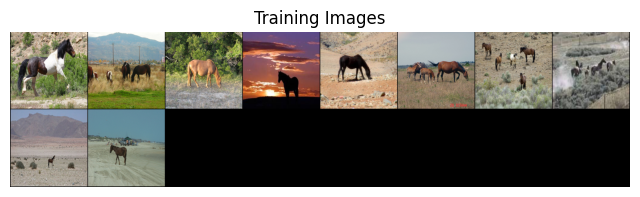

In [4]:
bs = 16
workers = 2
image_size = (256,256)
dataroot = '/HDD/n66104571/horses_train'
dataset_horses_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_horses = torch.utils.data.DataLoader(dataset_horses_train, 
                        batch_size=bs, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_horses))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], 
                             padding=2, normalize=True).cpu(),(1,2,0)))

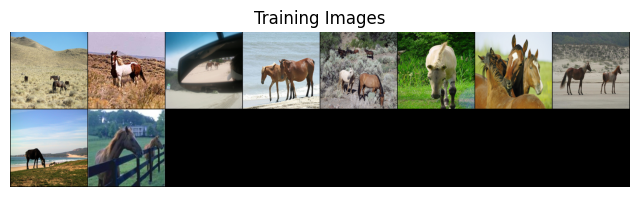

In [6]:
dataroot = '/HDD/n66104571/horses_test'
dataset_horses_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horses = torch.utils.data.DataLoader(dataset_horses_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_horses))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

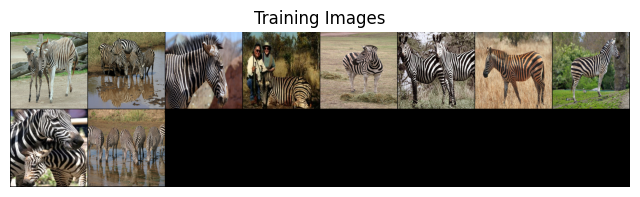

In [7]:
dataroot = '/HDD/n66104571/zebra_train'
dataset_zebra_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

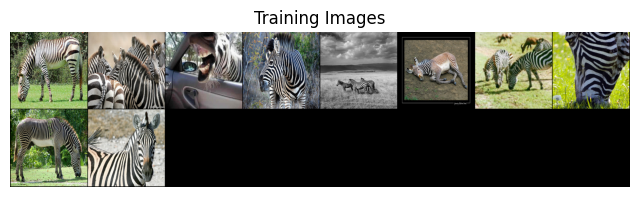

In [8]:
dataroot = '/HDD/n66104571/zebra_test'
dataset_zebra_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

## 定義繪製4個影像的函數：真實的馬、生成的斑馬、真實的斑馬、生成的馬

In [9]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    # 將馬變成斑馬
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2,
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
          
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()

    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    # 將斑馬變成馬
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

## 定義繪製8個影像的函數

In [10]:
def plot_all_images(image_number, dataloader_test_horses, dataloader_zebra_test): 
    #generate fake zebras
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()
    #generate fake horses
    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()
    #identity 
    identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity zebras")
    plt.show()
    #recovered image
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered zebras")
    plt.show()

## 定義模型存檔與載入的函數

In [11]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):
    torch.save(G_A2B, "./model/net_G_A2B.pth")
    torch.save(G_B2A, "./model/net_G_B2A.pth")
    torch.save(D_A, "./model/net_D_A.pth")
    torch.save(D_B, "./model/net_D_B.pth")

def load_models(name):
    G_A2B=torch.load("./model/"+name+"_G_A2B.pt")
    G_B2A=torch.load("./model/"+name+"_G_B2A.pt")
    D_A=torch.load("./model/"+name+"_D_A.pt")
    D_B=torch.load("./model/"+name+"_D_B.pt")
    return G_A2B, G_B2A, D_A, D_B

#save_models(G_A2B, G_B2A, D_A, D_B, "test")
#G_A2B, G_B2A, D_A, D_B= load_models("test")

## 定義生成網路訓練函數

In [12]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), 
                                            norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), 
                                            norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

## 定義判別網路訓練函數

In [13]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

## 定義判別網路及生成網路的損失函數

In [14]:
def LSGAN_D(real, fake):
    return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
    return  torch.mean((fake - 1)**2)

## 建立判別及生成網路

In [15]:
import itertools

G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Optimizers
# optimizer_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),
#                                lr=lr, betas=(0.5, 0.999))
optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

## 定義訓練模型的函數

In [17]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_A_losses = []
    D_B_losses = []


    iters=0
    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_A = []
    disc_B = []


    FDL_A2B_t = []
    FDL_B2A_t = []
    CL_A_t = []
    CL_B_t = []
    ID_B2A_t = []
    ID_A2B_t = []
    disc_A_t = []
    disc_B_t = []

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
            # Set model input
            a_real = data_horse[0].to(device)
            b_real = data_zebra[0].to(device)

            tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
            tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

            # Genrated images
            b_fake = G_A2B(a_real)
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)


            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(5, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
                D_A_losses.append(Disc_loss_A.item())
            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                D_A_losses.append(Disc_loss_A.item())
        
            Disc_loss_A.backward()
            optimizer_D_A.step()

        
            # Discriminator B
            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(5, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
                D_B_losses.append(Disc_loss_B.item())
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                D_B_losses.append(Disc_loss_B.item())

            Disc_loss_B.backward()
            optimizer_D_B.step()   

            # Generator
            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()

            # Fool discriminator
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            # Backward propagation
            Loss_G.backward()


            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()

            FDL_A2B.append(Fool_disc_loss_A2B)
            FDL_B2A.append(Fool_disc_loss_B2A)
            CL_A.append(Cycle_loss_A)
            CL_B.append(Cycle_loss_B)
            ID_B2A.append(Id_loss_B2A)
            ID_A2B.append(Id_loss_A2B)
            disc_A.append(Disc_loss_A)
            disc_B.append(Disc_loss_B)

            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
                
            elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
                
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del data_zebra, data_horse, a_real, b_real, a_fake, b_fake


            if iters % 50 == 0:   
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
        plot_images_test(dataloader_test_horses, dataloader_zebra_test)
    
    return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [19]:
name = 'basic_training200'
epochs=200
losses = training(G_A2B, G_B2A, D_A, D_B, epochs, name, old = False)

Starting Training Loop...
[1/200]	FDL_A2B: 0.3000	FDL_B2A: 0.3523	CL_A: 0.5521	CL_B: 0.7148	ID_B2A: 0.9600	ID_A2B: 1.3085	Loss_D_A: 0.5022	Loss_D_A: 0.4619
[2/200]	FDL_A2B: 0.3525	FDL_B2A: 0.3596	CL_A: 0.5463	CL_B: 0.5823	ID_B2A: 0.9480	ID_A2B: 1.0344	Loss_D_A: 0.4391	Loss_D_A: 0.4424


KeyboardInterrupt: 

## 存檔

In [ ]:
load_models(name)

plot_all_images(5, dataloader_test_horses, dataloader_zebra_test)